Philippe Joly 27-09-24

@Author  : Linbo<linbo.me>

@Version: 1.0    25/10/2014

This is the implementation of the Zhang-Suen Thinning Algorithm for skeletonization.
source code: https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm/tree/master

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import networkx as nx

import skimage.io as io
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage import morphology

# Knot and Rope Skeletonization

In [143]:
i= 1
img_original =  io.imread(f'./examples/{i}_knot.png')[...,:3]      
img_gray = rgb2gray(img_original)

## Region-Based Segmentation

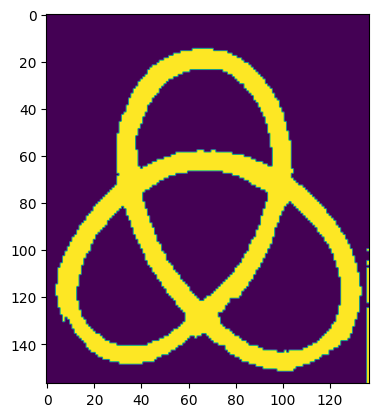

In [144]:
elevation_map = sobel(img_gray)

markers = np.zeros_like(img_gray)
markers[img_gray<30/255]=1
markers[img_gray>150/255]=2
markers = markers.astype(np.int32)

bw = watershed(elevation_map, markers)-1
plt.imshow(bw)

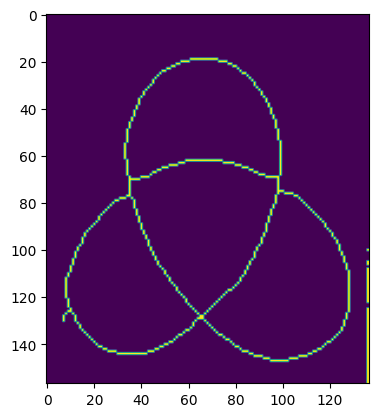

In [145]:
sk = morphology.skeletonize(bw)
plt.imshow(sk)

## Zhang's Algorithm 

In [146]:
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

## Results

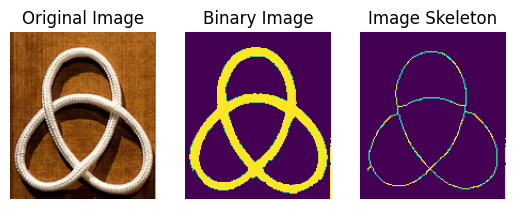

In [147]:
skeleton = zhangSuen(bw)
fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.ravel()
ax1.imshow(img_original)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(bw)
ax2.set_title('Binary Image')
ax2.axis('off')

ax3.imshow(skeleton)
ax3.set_title('Image Skeleton')
ax3.axis('off')
plt.show()

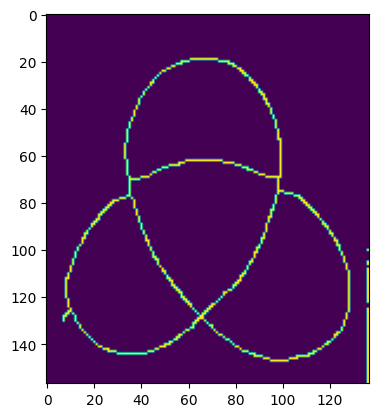

In [148]:
sk = morphology.remove_small_objects(skeleton*255, 500, connectivity=2)
plt.imshow(sk)

# Graph transposition and cleaning

In [149]:
def show_graph(G):
    plt.figure(figsize=(10, 10))
    pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Flip y-axis for correct orientation
    nx.draw(G, pos, node_size=1, node_color='blue', with_labels=False)
    plt.title("Graph Representation")
    plt.axis('off')
    plt.show()

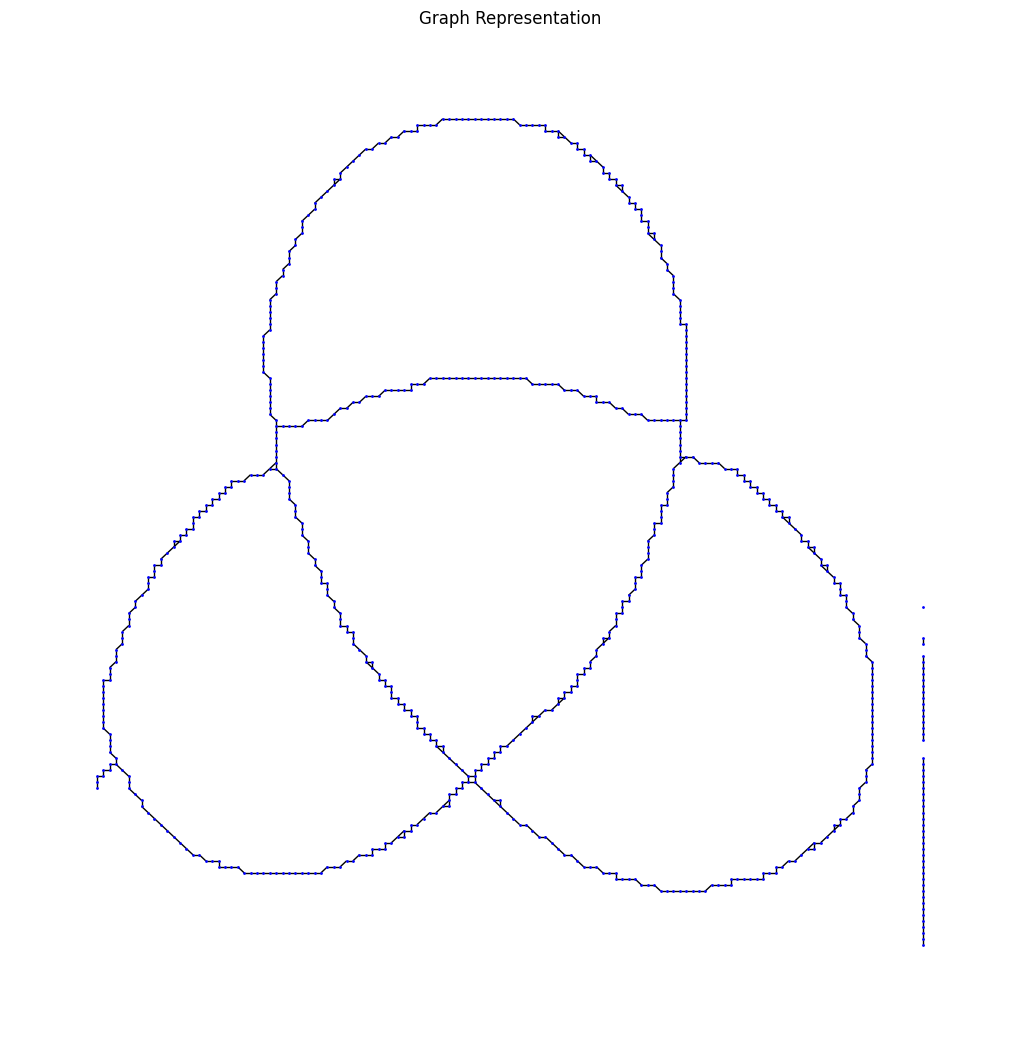

In [150]:
def sk_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for r in range(rows):
        for c in range(cols):
            if skeleton[r, c]:
                G.add_node((r, c))

    # Add edges between adjacent pixels
    slants = [(-1, -1),(-1, 1),(1, -1),(1, 1)]
    
    directions = [(-1, 0),(0, -1),(0, 1),(1, 0)]

    for node in G.nodes():
        r, c = node
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if (nr, nc) in G.nodes():
                G.add_edge((r, c), (nr, nc))
        
        if G.degree((r,c))<2:
            for dr, dc in slants:
                nr, nc = r + dr, c + dc
                if (nr, nc) in G.nodes():
                    G.add_edge((r, c), (nr, nc))
            
    return G

G = sk_graph(skeleton)
show_graph(G)

In [151]:
# Remove small loops

def remove_loops(G):
    for i, node in enumerate(G.nodes):
        if G.degree(node) > 2:
            for neighbour in G.neighbors(node):
                flag = False
                if neighbour !=list(G.nodes)[i-1]:
                    flag = search_loop(G, node, node, neighbour, 0)

                if flag:
                    break

def search_loop(G, init_node, prev_node, node, count):
    if node == init_node:
        G.remove_edge(prev_node, node)
        return True
    
    flag = False 

    if count < 5:
        for neighbour in G.neighbors(node):
            if neighbour != prev_node:
                flag = search_loop(G, init_node, node, neighbour, count+1)

            if flag:
                break

    return flag


In [152]:
remove_loops(G)     
# show_graph(G)

In [153]:
# remove unlooped branches
def remove_unconnected(G):
    removable = []

    for node in G.nodes:
        if G.degree(node) < 2:
            search_branch(G, None, node, removable)
    
    removable = list(set(removable))
    for node in removable:
        G.remove_node(node)

def search_branch(G, prev_node, node, removable):
    if G.degree(node) > 2:
        return
    
    removable.append(node)
    for neighbour in G.neighbors(node):
        if neighbour != prev_node:
            search_branch(G, node, neighbour, removable)

In [154]:
remove_unconnected(G)
# show_graph(G)

In [155]:
# connect close intersections

def connect_int(G):
    ints = []
    connections = []
    removes = []
    for i, node in enumerate(G.nodes):
        if G.degree(node) > 2:
            for neighbour in G.neighbors(node):
                if neighbour != list(G.nodes)[i-1]:
                    inter, removable = search_int(G, node, neighbour, 0, [])
                    if inter and (inter, node) not in connections:
                        ints.extend([node,inter])
                        connections.append((node, inter))
                        removes.extend(removable)
    
    removes = list(set(removes))
    for node in removes:
        G.remove_node(node)
    
    new_ints = []
    for int1, int2 in connections:
        r, c = (int1[0]+int2[0])//2, (int1[1]+int2[1])//2
        G.add_node((r, c))
        new_ints.append((r,c))

        for neighbour in list(G.neighbors(int1))+list(G.neighbors(int2)):
            if neighbour != (r,c):
                G.add_edge((r,c), neighbour)
    
    ints = list(set(ints))
    for node in ints:
        if node not in new_ints:
            G.remove_node(node)

    return new_ints

def search_int(G, prev_node, node, count, removable):
    if G.degree(node) > 2:
        return node, removable
    
    if count > 10:
        return None, None

    for neighbour in G.neighbors(node):
        if neighbour != prev_node:
            removable.append(node)
            return search_int(G, node, neighbour, count+1, removable)    

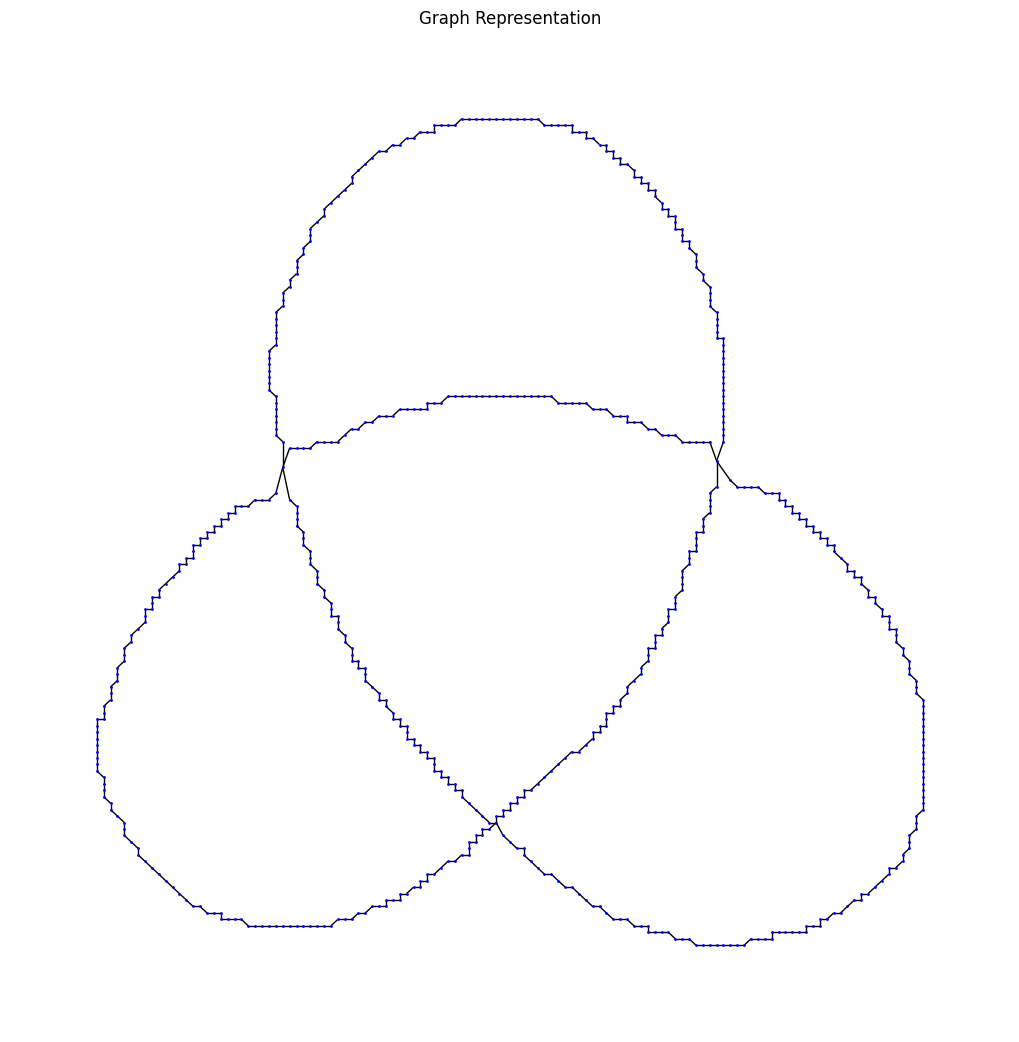

In [156]:
new_ints = connect_int(G)
show_graph(G)

# Crossing Analysis

In [157]:
new_ints

[(72, 98), (73, 35), (128, 66)]

In [ ]:
img